# Анализ сервиса аренды самокатов GoFast #

# Задача проекта #

У нас есть данные популярного сервиса аренды самокатов GoFast о некоторых пользователях из разных городов, а также об их поездках. Нужно проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти. Узнать, есть ли отличия между информацией от людей, которые купили подписку, и тех, кто этого не сделал.

## Загрузка данных ##

Импортируем нужные для анализа библиотеки

In [1]:
import os
import pandas as pd
import numpy as np 
import scipy.stats as st # эта и ниже библиотеки понадобятся нам ближе к концу
from scipy.stats import binom, poisson
from matplotlib import pyplot as plt
from math import sqrt
from scipy import stats as st


Считаем и посмотрим CSV-файлы с данными сервиса аренды самокатов GoFast

In [2]:
if os.path.exists('users_go.csv') and os.path.exists('rides_go.csv') and os.path.exists('subscriptions_go.csv'):
    user = pd.read_csv('users_go.csv')
    display(user.head())
    print(user.shape)
    rides = pd.read_csv('rides_go.csv', parse_dates=['date'])
    display(rides.head())
    print(rides.shape)
    subscriptions = pd.read_csv('subscriptions_go.csv')
    display(subscriptions.head())
    print(subscriptions.shape)
    
elif os.path.exists('/datasets/users_go.csv') and os.path.exists('rides_go.csv') and os.path.exists('subscriptions_go.csv'):
    user = pd.read_csv('/datasets/users_go.csv')
    display(user.head())
    print(user.shape)
    rides = pd.read_csv('/datasets/rides_go.csv', parse_dates=['date'])
    display(rides.head())
    print(rides.shape)
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
    display(subscriptions.head())
    print(subscriptions.shape)
    
else:
    print('File read error')

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


(1565, 5)


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


(18068, 4)


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


(2, 4)


На первый взгляд все понятно, нет чего-то выделяющегося, кроме данных в таблице rides. Стобец distance и duration имеет много значений после точки, но это легко будет исправить. И столбик date имеет тип object

## Предобработка данных

In [3]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Сначала округлим значения в столбцах distance и duration(округлим его в большую сторону, т.к. это понадобится потом в проекте) таблицы rides и поменяем типы данных со столбцом date

In [4]:
rides['distance'] = rides['distance'].round()
rides['duration'] = np.ceil(rides['duration']) 
rides['distance'] = rides['distance'].astype('int')
rides['duration'] = rides['duration'].astype('int')

In [5]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  int32         
 2   duration  18068 non-null  int32         
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(2), int64(1)
memory usage: 423.6 KB


In [6]:
rides['month'] = rides['date'].dt.month # создали столбец с месяцем

Посмотрим на пропуски

In [7]:
print(user.isna().sum())
print()
print(rides.isna().sum())
print()
print(subscriptions.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


Пропусков не замечено. Проверим дубликаты

In [8]:
print(len(user['user_id']))
user = user.drop_duplicates().reset_index(drop=True)
print(len(user['user_id']))

1565
1534


удалили 31 кол-во очевидных дубликатов

In [9]:
rides['duration'].unique()

array([26, 16,  7, 19, 27, 17, 15, 24, 18, 10, 25, 12, 21, 14, 13, 22, 20,
       23, 28, 36, 34, 11,  6, 31, 33,  8, 29, 39, 32, 30,  9,  5, 37, 35,
       40, 38, 41,  4,  1,  3])

Аномалий со временем поездок нет

На данном шаге мы предобработали данные, округлив некоторые значения, изменив тип дынных, создав новый столбец с месяцем и удалив дубликаты. Все это поможет нам с дальнейшей работой над проектом

## Исследовательский анализ данных

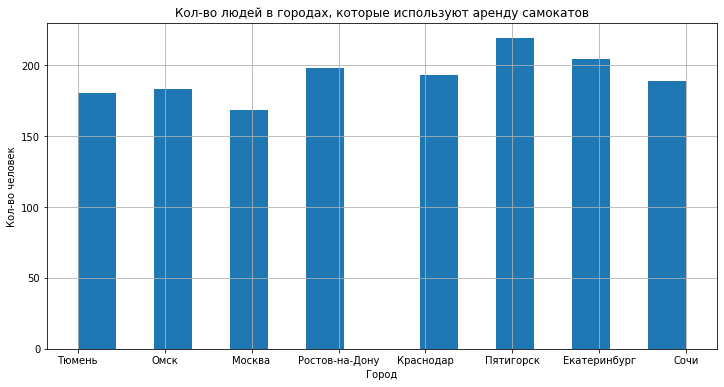

In [10]:
#частота встречаемости городов
user['city'].hist(bins=16, figsize=(12,6))
plt.xlabel('Город')
plt.ylabel('Кол-во человек')
plt.title('Кол-во людей в городах, которые используют аренду самокатов');

по гистограмме видно, что больше всего зарегистрировано людей из Пятигорска. А так, все значения достаточно близки и находятся в районе 190

                   user_id  name  age  city
subscription_type                          
free                   835   835  835   835
ultra                  699   699  699   699


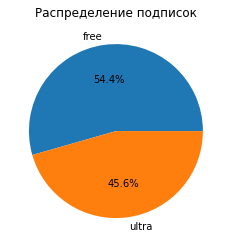

In [11]:
# соотношение пользователей с подпиской и без подписки
q = user.groupby('subscription_type').count()
print(q)
sizes = [835, 699]  # Пример значений столбцов "free" и "ultra"
labels = ['free', 'ultra']
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Распределение подписок')
plt.show()

Людей без подписки практически на 10 % больше, чем с подпиской

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

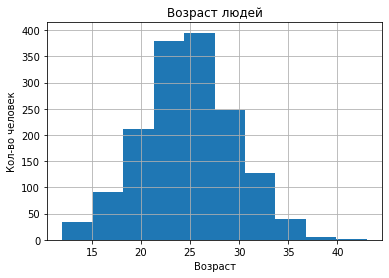

In [12]:
# возраст пользователей
user['age'].hist()
plt.xlabel('Возраст')
plt.ylabel('Кол-во человек')
plt.title('Возраст людей')
user['age'].describe()

похоже на нормальное распределение, что достаточно логично. Больше всего зарегестрированных людей в возрасте 25 лет. 50 % значений лежат в промежутке от 22 до 28 лет. Бывают клиенты 12 и 43 лет

Text(0.5, 1.0, 'Расстояние, которе проехал пользователь')

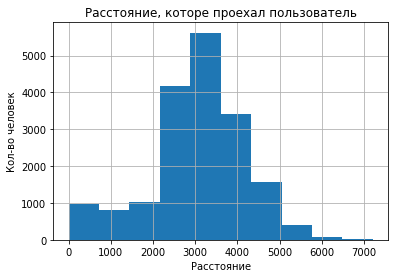

In [13]:
#  расстояние, которое пользователь преодолел за одну поездку
rides['distance'].hist()
plt.xlabel('Расстояние')
plt.ylabel('Кол-во человек')
plt.title('Расстояние, которе проехал пользователь')

Чаще всего люди осуществляют поездки на дистанции около 3 км. На гистограмме заметен резкий переход кол-ва поездок от 2 км до 3 км.

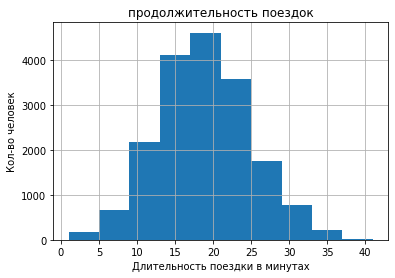

In [14]:
rides['duration'].hist()
plt.xlabel('Длительность поездки в минутах')
plt.ylabel('Кол-во человек')
plt.title('продолжительность поездок');

Похоже на гистограмму с дистанцией, что логично, т.к. они связаны между собой. Самые частые поезди от 15 до 20 минут

По информации о пользователях и поездках можно сказать, что данные удобные, т.к. гистограммы имеют нормальное распределение, а столбцы subscription_type и city не имеют значений, которые сильно выделяются

## Объединение данных

Для удобной работы, соединим три таблицы в один датафрейм и создадим отдельные - с подписками и без

In [15]:
print('Длина до:', len(rides['user_id'])) # возьмем таблицу с наибольшим числом строк, т.к. в новой должно оказаться столько же
general = user.merge(rides, on = 'user_id', how = 'left') # создаем общую таблицу из двух первых
general = general.merge(subscriptions, on = 'subscription_type', how = 'left') # и из прошлой и третьей таблицы создаем общую из 3
print('Длина после:', len(general['user_id']))
print()
print('Кол-во пропусков в столбцах:')
print(general.isna().sum())
print()
general.head()

Длина до: 18068
Длина после: 18068

Кол-во пропусков в столбцах:
user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64



,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4410,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2618,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754,7,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2695,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4029,27,2021-08-28,8,6,0,199


In [16]:
with_ultra = general.query('subscription_type == "ultra"') #таблица с платными подписками
with_ultra = with_ultra.reset_index(drop=True)
with_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4410,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2618,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754,7,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2695,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4029,27,2021-08-28,8,6,0,199


In [17]:
with_free = general.query('subscription_type == "free"') #таблица с бесплатными подписками
with_free = with_free.reset_index(drop=True)
with_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2516,15,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,847,17,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004,21,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1206,10,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047,18,2021-02-14,2,8,50,0


Посмотрим на информацию о расстоянии и времени поездок для пользователей обеих категорий

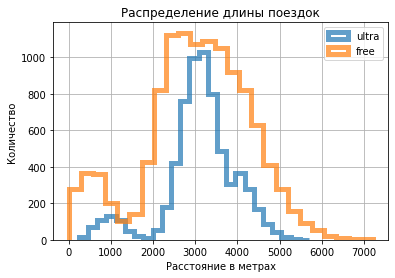

In [18]:
ax = with_ultra.plot(
    kind='hist',
    y='distance',
    histtype='step',
    bins=25,
    linewidth=5,
    alpha=0.7,
    label='ultra',
)
with_free.plot(
    kind='hist',
    y='distance',
    histtype='step',
    bins=25,
    linewidth=5,
    alpha=0.7,
    label='free',
    ax=ax,
    grid=True,
    legend=True,
) 
ax.set_xlabel('Расстояние в метрах')
ax.set_ylabel('Количество')
ax.set_title('Распределение длины поездок');

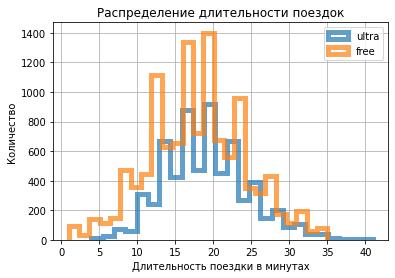

In [19]:
ax = with_ultra.plot(
    kind='hist',
    y='duration',
    histtype='step',
    bins=25,
    linewidth=5,
    alpha=0.7,
    label='ultra',
)
with_free.plot(
    kind='hist',
    y='duration',
    histtype='step',
    bins=25,
    linewidth=5,
    alpha=0.7,
    label='free',
    ax=ax,
    grid=True,
    legend=True,
) 
ax.set_xlabel('Длительность поездки в минутах')
ax.set_ylabel('Количество')
ax.set_title('Распределение длительности поездок');

На обоих графиках заметно, что расстояние и длительность поездок у людей с подпиской и без очень похожи. Просто кол-во людей с подпиской меньше, поэтому синия кривая линия ниже

## Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе general и добавим столбец с помесячной выручкой

In [20]:
general_plus = general.groupby(['user_id', 'month']
                            ).agg({'distance':'sum', 'duration':['sum', 'count'],
                                   'subscription_type':'first',
                                   'minute_price':'first',
                                   'start_ride_price':'first',
                                   'subscription_fee':'first'})

general_plus.columns = ['sum_distance', 'sum_duration', 'count_rides',
                          'subscription_type', 'minute_price',
                          'start_ride_price', 'subscription_fee']
general_plus.reset_index(inplace=True)

display(general_plus.head())
print(general_plus.shape[0])

# добавим столбик с помесячной выручкой
general_plus['money'] = general_plus['start_ride_price'] * general_plus['count_rides'] + general_plus['minute_price'] * general_plus['sum_duration'] + general_plus['subscription_fee']
display(general_plus.head())
print(general_plus.shape[0])

,user_id,month,sum_distance,sum_duration,count_rides,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7028,42,2,ultra,6,0,199
1,1,4,754,7,1,ultra,6,0,199
2,1,8,6724,46,2,ultra,6,0,199
3,1,10,5810,32,2,ultra,6,0,199
4,1,11,7004,56,3,ultra,6,0,199


11331


,user_id,month,sum_distance,sum_duration,count_rides,subscription_type,minute_price,start_ride_price,subscription_fee,money
0,1,1,7028,42,2,ultra,6,0,199,451
1,1,4,754,7,1,ultra,6,0,199,241
2,1,8,6724,46,2,ultra,6,0,199,475
3,1,10,5810,32,2,ultra,6,0,199,391
4,1,11,7004,56,3,ultra,6,0,199,535


11331


Получилась таблица, отсортированная по user_id и month, с общей дистанцией, временем и кол-ом поездок за каждый месяц пользователей. Еще в ней есть информация о типе подписки, ее стоймости и стоймости за каждую минуту пути. Эта таблица поможет нам проперить гипотезы.

## Проверка гипотез

Проверим тратят ли пользователи с подпиской больше времени на поездки? Для этого возьмем за нулевую гипотезу, что среднее время поездок одинаковое. Альтернативная гипотеза: пользователи с подпиской тратят больше времени на поездки

In [21]:
print(with_ultra['duration'].mean())
print(with_free['duration'].mean())

with_ultra_dur = with_ultra['duration']
with_free_dur = with_free['duration']   
alpha = 0.05 # уровень статистической значимости
results = st.ttest_ind(with_ultra_dur, with_free_dur, alternative='greater')     
print(f'p-value: {results.pvalue}')     
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

19.037692307692307
17.890992392807746
p-value: 2.495945372073663e-34
Отвергаем нулевую гипотезу


если мы отвергнули нулевую гипотезу, то это значит, что пользователи с подпиской тратят больше своего времени на поездки.

Теперь проверим гипотезу о том, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 
3130 метров. Нулевая гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров. Альтернативная: пользователи с подпиской проезжают в среднем за одну поездку больше 3130 м

In [22]:
print(with_ultra['distance'].mean())

with_ultra_dist = with_ultra['distance']
prev_screens_value = 3130
alpha = 0.05
results = st.ttest_1samp(
    with_ultra_dist, 
    prev_screens_value,
    alternative = 'greater'
      )
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу') 

3115.4433846153847
p-значение: 0.9195649894697724
Не отвергаем нулевую гипотезу


Из этого следует, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 
3130 метров. А это означает, что оптимальное значение с точки зрения износа самоката не превышается.

Давайте узнаем будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки? Для этого нулевая гипотеза будет такой: помесячная выручка по месяцам у двух групп будет одинакова. Альтернативная: у людей с подпиской будет выручка в среднем больше.

In [23]:
easy_money_ultra = general_plus[general_plus['subscription_type'] == 'ultra']['money']
easy_money_free = general_plus[general_plus['subscription_type'] == 'free']['money']
alpha = 0.05

results = st.ttest_ind(easy_money_ultra, easy_money_free, alternative='greater')  
print(f'p-value: {results.pvalue}')     
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Это означает, что компании будет выгоднее иметь больше клиентов с подпиской, чем без.

Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение и она надеется, что из-за этого количество обращений в техподдержку значимо снизится. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Для проверки этой гипотезы нам понадобится метод scipy.stats.ttest_rel, тк у нас есть две зависимые выборки, которые нужно проверить на равенство среднего значения до и после изменения. Нам надо будет проверить односторонную гипотезу с параметром alternative = 'less', т.к. кол-во обращений должно по задумке снизиться

Результаты проперки гипотез получились следующие: пользователи с подпиской тратят больше своего времени на поездки. Пользователи не превышают оптимальное значение с точки зрения износа самоката. И компании выгоднее иметь больше клиентов с подпиской, чем без.

## Распределения

Нужно выяснить, какое минимальное кол-во промокодов нужно разослать, если каждый 10 пользователь продлит ее в будущем, чтобы в итоге минимум 100 пользователей ее продлили. При этом вероятность не выполнить план была примерно 5%. Для этого посчитаем параметры распределения, описывающего эту ситуацию, построим график распределения и сформулируем ответ на вопрос о количестве промокодов.

841


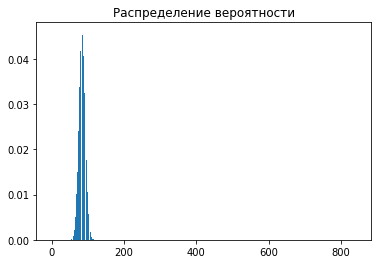

In [24]:
# найдем минимальное кол-во промокодов, которые нужно разослать, чтобы вероятность не выполнить план была примерно 5%
p = 0.1 # вероятность успеха (продления подписки)
threshold = 100 # сколько подписок нужно
target_prob = 0.05 # вероятность не выполнить план
w = 1 # переменная, хранящая минимальную разницу
n = 0 # переменная, которая хранит кол-во экспериментов
for N in range(1, 1000):
    lamba = N * p
    q = 1 - poisson.cdf(threshold - 1, lamba)
    if abs(q - 0.05) < w:
        w = abs(q - 0.05)
        n = N 
print(n)
# теперь построим гистограмму распределения
np.seterr(divide = 'ignore')
p = 0.1

from scipy.stats import binom

distr = []

for k in range(0, n + 1):
    current_value = binom.pmf(k, n, p)
    distr.append(current_value)
    
plt.bar(range(0, n + 1), distr)
plt.title('Распределение вероятности')
plt.show();

Для того чтобы получить минимальное количество подписок, нужно разослать примерно 841 промокод

Оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей. При условии, что уведомления открывают около 40 % получивших клиентов, а отдел планирует разослать 1 млн уведомлений.

In [25]:
n = 1000000
p = 0.4
mu = n * p
sigma = sqrt(n * p * (1 - p))
distr = st.norm(mu, sigma) 
result = distr.cdf(399500)
print(result)

0.15371708296369768


вероятность того, что уведомление откроют не более 399,5 тыс. пользователей приблизительно равна 15%

## Общий вывод ##

В данном проекте мы проанализировали данные аренды самокатов сервиса GoFast, в которых было три таблицы с данными о пользователях(user_id - уникальный идентификатор пользователя, name - имя пользователя, age - возраст, city - город, subscription_type - тип подписки), поездках(user_id - уникальный идентификатор пользователя, distance - расстояние, duration - продолжительность сессии, date - дата совершения поездки) и подписках(subscription_type - тип подписки, minute_price - стоимость одной минуты поездки по данной подписке, start_ride_price - стоимость начала поездки, subscription_fee - стоимость ежемесячного платежа). Для этого мы ознакомились и сохранили эти данные в датафреймы. После этого занялись предобработкой данных, в которой создали новый столбец с номером месяца на основе столбца date, приведя его в тип date. Обработали дубликаты. Сделали исследовательский анализ данных, описав и визуализировав общую информацию о пользователях и поездках. Затем объединили данные о пользователях, поездках и подписках в один датафрейм. Создали еще пару таблиц с подписками и без. Визуализировали информацию о расстоянии и времени поездок для пользователей обеих категорий. Посчитали выручки с помесячной выручкой, которую принёс каждый пользователь. После этого проверили некоторые гипотезы, как: тратят ли пользователи с подпиской больше времени на поездки, среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает ли оно 3130 метров, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Помогли провести акцию с раздачей промокодов и разослать клиентам push-уведомления в мобильном приложении.